### What is this? 
*This is a fully functional Jupyter notebook running on a Julia kernel.*

### How to use this document?
*To execute the code in a cell, press `Shift` + `Enter` when the cell is active. After starting a new notebook, it is necessary to execute each code cell at least once to get the interactive plot functionality!*

### Changing stuff
*Feel free to change the code as you like, but before doing so, please go to `File -> Make a new copy...` and edit a copy of this notebook. You can download the whole notebook in `.ipynb`-format, or as non-interactive `.pdf`. The plot can be saved as a png*

### What to do, when things go wrong?
*You can simply restart the kernel using `Kernel -> Restart`*

### Shutting down
*Once you're done, save your changes, then exit shut down the notebook via: `File -> Close and halt`*

Enjoy!

In [1]:
#Load required packages
using XPP
using DataFrames
using Interact, Reactive
using PyPlot

# The Model

We assume that the phosphorylation-state of a substrate $pS$ is regulated as follows:

- $k_{pind}$ Phosphorylation by an constitutively active kinase
- $k_{gwl}$ Phosphorylation by Greatwall kinase, affected by Greatwall depletion
- $k_{ind}$ Dephosphorylation by a consititutively active phosphatase
- $k_{b55}$ Dephosphorylation by PP2A:B55, affected by Greatwall and B55 depletion
- $k_{egwl}$ Rate of Phosphorylation of ENSA by Gwl

$$pS' = (k_{pind} + k_{gwl} \cdot Gwl) * S - (k_{ind} + k_{b55} \cdot B55) * pS $$
$$pEt' = k_{egwl} \cdot E \cdot Gwl - k_{cat} \cdot pEB $$
$$pEB' = k_{ass} \cdot B \cdot pE - (k_{diss} + k_{cat}) \cdot pEB $$


In [15]:
# Differential equation
odes = Dict(
"pS" => "(k_pind + k_gwl * Gwl) * (St - pS) - (k_ind + k_b55 * B)*pS",
    "pEt" => "k_egwl * (Et - pEt) * Gwl - (k_diss + k_cat) * pEB",
    "pEB" => "k_ass * B * pE - (k_diss + k_cat) * pEB"
);
#Algebraic equations
alg = Dict(
    "B" => "Bt - pEB",
    "pE" => "pEt - pEB"
)
# Initial condition
init = Dict(
    "pS" => 0.0,
    "pEt" => 0.0,
    "pEB" => 0.0,
);
#Parameters - Just initialised, will be set interactively
pars = Dict(
    "k_pind" => 0.0,
"k_gwl" => 0.0,
    "k_ind" => 0.0,
    "k_b55" => 0.0,
    "k_egwl" => 0.0,
    "k_diss" => 0.0,
    "k_ass" => 0.0,
    "k_cat" => 0.0,
    "Gwl" => 0.0,
    "Bt" => 0.0,
    "Et" => 0.0,
    "St" => 1,
);
M = Model(odes, init, pars, name = "Phosphorylation-Model", alg = alg);

Vectorisation of model
ASCIIString["p[10] * (p[6] - y[1]) * p[5] - (p[9] + p[12]) * y[2]","p[1] * (p[2] - y[2]) * (y[1] - y[2]) - (p[9] + p[12]) * y[2]","(p[7] + p[3] * p[5]) * (p[4] - y[3]) - (p[8] + p[11] * (p[2] - y[2]))*y[3]"]
Any[]


# Kinase Inactivation

We model two domains for the system:

- Phosphorylation of the substrate, when B55 is largely inactive and kinases are active. Defined by *t1*
- Dephosphorylation of the susbtrate where kinases are inactivated.

This is captured by the following function:

In [16]:
function inactivateKinase(M, t2, name)
    #Set the new initial conditions for the simulations to the last values of the simulation of the phos.-domain
    M.init = [v => M.sims[name*"_1"].D[v][end] for v in keys(M.init)]
    #Inactivate the kinases
    M.pars["Gwl"] = 0
    M.pars["k_pind"] = 0
    simulate!(M, name * "_2", 0:0.01:t2)
    #Restore model to initial state...
    restoreModel!(M)
end

inactivateKinase (generic function with 1 method)

# Modelling Depletion

To capture the depletion of B55 and Gwl, we reduce the total pool of Gwl or B55 by a factor:

In [17]:
function simulateConditions(M, t1, t2, Gwl, Gwl_depletion, Bt, B55_depletion)
    checkpoint!(M)
    # Simulate Control
    M.pars["Bt"] = Bt
    M.pars["Gwl"] = Gwl
    simulate!(M, "Control_1", 0:0.01:t1)
    inactivateKinase(M, t2, "Control")
    
    # Simulate B55-Depletion
    M.pars["Bt"] = Bt * B55_depletion
    M.pars["Gwl"] = Gwl
    simulate!(M, "B55_1", 0:0.01:t1)
    inactivateKinase(M, t2, "B55")
    
    # Simulate Gwl-Depletion
    M.pars["Bt"] = Bt
    M.pars["Gwl"] = Gwl * Gwl_depletion
    simulate!(M, "Gwl_1", 0:0.01:t1)
    inactivateKinase(M, t2, "Gwl")
end

simulateConditions (generic function with 1 method)

In [18]:
# Helper function to get and assemble data from the two simulaton domains
function getData(M, name, y)
    t_1 = M.sims[name*"_1"].D["t"]
    y_1 = M.sims[name*"_1"].D[y]
    t_2 = M.sims[name*"_2"].D["t"]
    y_2 = M.sims[name*"_2"].D[y]
    return [t_1 - t_1[end]; t_2], [y_1; y_2], y_1[end]
end

#Plot pS and ENSA
function plotSimulations(M, ti, normalise_by_ctrl)
    sp = subplot(111)
    #Get substrate data
    t_c, ctrl, ctrl_1 = getData(M, "Control", "pS")
    t_b, b55, b55_1 = getData(M, "B55", "pS")
    t_g, gwl, gwl_1 = getData(M, "Gwl", "pS")
    # Get Ensa data
    t_c, ectrl, ectrl_1 = getData(M, "Control", "pEt")
    t_b, eb55, eb55_1 = getData(M, "B55", "pEt")
    t_g, egwl, egwl_1 = getData(M, "Gwl", "pEt")
    
    #Normalise relative to control
    if normalise_by_ctrl
        ctrl = ctrl./ctrl_1
        b55 = b55./ctrl_1
        gwl = gwl./ctrl_1
        ectrl = ectrl./ectrl_1
        eb55 = eb55./ectrl_1
        egwl = egwl./ectrl_1
    end    
    
    sp[:plot](t_c,ctrl, color = "#5fbdff", linewidth = 2, label = "pS Ctrl")
    sp[:plot](t_b,b55, color = "#ffc900", linewidth = 2, label = "pS B55")
    sp[:plot](t_g,gwl, color = "#5fbd00", linewidth = 2, label = "pS Gwl")
    sp[:plot](t_c,ectrl, color = "#5fbdff", linewidth = 2, linestyle = "--", label = "pEt Ctrl")
    sp[:plot](t_b,eb55, color = "#ffc900", linewidth = 2, linestyle = "--", label = "pEt B55")
    sp[:plot](t_g,egwl, color = "#5fbd00", linewidth = 2, linestyle = "--", label = "pEt Gwl")
    sp[:set_xlabel]("time (min)")
    sp[:set_ylabel]("pS")
    title(ti)
    legend()
        
end

plotSimulations (generic function with 1 method)

# Interactive model

Execute the cell below first, then change values in the textboxes or move sliders to change the model parameters

Interact.Textbox{AbstractString}(Signal{AbstractString}(Analysis of Phosphorylation, nactions=0),"title",nothing,"Analysis of Phosphorylation")

Interact.Textbox{Float64}(Signal{Float64}(1.0, nactions=0),"Gwl",nothing,1.0)

Interact.Textbox{Float64}(Signal{Float64}(0.7303, nactions=0),"Bt",nothing,0.7303)

Interact.Textbox{Float64}(Signal{Float64}(2.3, nactions=0),"Et",nothing,2.3)

Interact.Textbox{Float64}(Signal{Float64}(0.1, nactions=0),"Gwl_depletion",nothing,0.1)

Interact.Textbox{Float64}(Signal{Float64}(0.3099, nactions=0),"B55_depletion",nothing,0.3099)

Interact.Textbox{Float64}(Signal{Float64}(8.2551, nactions=0),"k_ass",nothing,8.2551)

Interact.Textbox{Float64}(Signal{Float64}(0.001, nactions=0),"k_diss",nothing,0.001)

Interact.Textbox{Float64}(Signal{Float64}(0.165, nactions=0),"k_cat",nothing,0.165)

Interact.Textbox{Int64}(Signal{Int64}(45, nactions=0),"t1",nothing,45)

Interact.Textbox{Int64}(Signal{Int64}(45, nactions=0),"t2",nothing,45)

Interact.Checkbox(Signal{Bool}(true, nactions=0),"normalise_by_ctrl",true)

Interact.Textbox{Float64}(Signal{Float64}(0.12, nactions=0),"k_pind",nothing,0.12)

Interact.Textbox{Float64}(Signal{Float64}(0.6, nactions=0),"k_gwl",nothing,0.6)

Interact.Textbox{Float64}(Signal{Float64}(0.08, nactions=0),"k_egwl",nothing,0.08)

Interact.Textbox{Float64}(Signal{Float64}(0.0, nactions=0),"k_ind",nothing,0.0)

Interact.Textbox{Float64}(Signal{Float64}(0.12, nactions=0),"k_b55",nothing,0.12)

Interact.Textbox{Float64}(Signal{Float64}(20.0, nactions=0),"St",nothing,20.0)

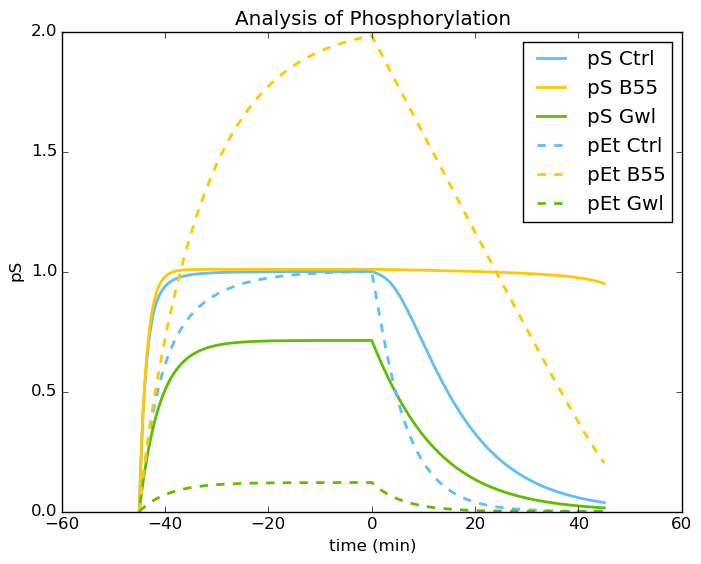

In [20]:
f = figure()
@manipulate for 
    title="Analysis of Phosphorylation", # Title of the plot
    Gwl=1.0,
    Bt=0.7303,
    Et=2.3,
    Gwl_depletion=0.1,
    B55_depletion=0.3099,
    k_ass=8.2551,
    k_diss=0.001,
    k_cat=0.165,
    t1=45, # Duration of simulation of phosphorylation domain
    t2=45, # Duration of simulation of dephosphorylation domain
    normalise_by_ctrl=true,
    k_pind=0.12,
    k_gwl=0.6,
    k_egwl=0.08,
    k_ind=0.0,
    k_b55=0.12,
    St=20.0;
    withfig(f) do
        # Update the parameters
        M.pars= Dict(
            "k_pind" => k_pind,
            "k_ind" => k_ind,
        "k_gwl" => k_gwl,
            "k_egwl" => k_egwl,
            "k_b55" => k_b55,
            "k_ass" => k_ass,
            "k_diss" => k_diss,
            "k_cat" => k_cat,
            "Gwl" => Gwl,
            "Bt" => Bt,
            "Et" => Et,
            "St" => St,
        )
        simulateConditions(M, t1, t2, Gwl, Gwl_depletion, Bt, B55_depletion)
        plotSimulations(M, title, normalise_by_ctrl)

    end
end

## Interesting:

- See how `Gwl_depletion` affects the steady states!
- As long as `k_pind` is not 0, its actual numerical does not affect the steady state (If we normalise by control)!
- If `k_egwl` is set to `0.08`, we can nicely capture the initial conditions observed for ENSA.
